In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = nn.Linear(4, 64)
        self.dense2 = nn.Linear(64, 2)

        nn.init.kaiming_normal_(self.dense1.weight, nonlinearity='relu')
        with torch.no_grad():
            self.dense2.weight *= 0.1

    def forward(self, x):
        x = F.relu(self.dense1(x))
        x = F.softmax(self.dense2(x), dim=1)
        return x

In [20]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

EPISODES = 10000

env = gym.make("CartPole-v1", render_mode="rgb_array")

policy = Model()
optimizer = torch.optim.Adam(policy.parameters(), lr=1e-4)

discount = 0.99
losses = []
rewards = []
max_reward = 0

for e in range(EPISODES):
    observation, info = env.reset()

    steps = []

    episode_over = False
    running = 0
    while not episode_over:
        # frame = env.render()
        # clear_output(wait=True)
        # plt.imshow(frame)
        # plt.axis('off')
        # plt.show()
        # time.sleep(0.002)

        # action = env.action_space.sample()  # agent policy that uses the observation and info
        probs = policy(torch.from_numpy(observation).view(1, -1))
        action = torch.multinomial(probs, num_samples=1).item()
        observation, reward, terminated, truncated, info = env.step(action)

        steps.append((observation, action, reward))
        running += reward

        episode_over = terminated or truncated
    
    rewards.append(running)
    if running > max_reward:
        max_reward = running
        print(f"New max of {max_reward}")

    returns = []
    R = 0
    for _, _, r in reversed(steps):
        R = r + discount * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)

    loss = 0
    optimizer.zero_grad()
    for (s, a, _), R in zip(steps, returns):
        prob = policy(torch.from_numpy(s).view(1, -1))
        loss += -prob[0, a].log() * R

    loss.backward()
    nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
    optimizer.step()

    losses.append(loss.item())

    if (e + 1) % 500 == 0:
        print(f"Episodes {(e - 499, e)}: Avg Loss- {sum(losses[e-499:e])/500}, Avg Return- {sum(rewards[e-499:e])/500}")
        
env.close()

New max of 28.0
New max of 44.0
New max of 45.0
New max of 46.0
New max of 59.0
New max of 63.0
New max of 70.0
New max of 74.0
New max of 75.0
New max of 86.0
New max of 87.0
Episodes (0, 499): Avg Loss- -0.175027503490448, Avg Return- 23.262
New max of 118.0
Episodes (500, 999): Avg Loss- -0.5066174696683884, Avg Return- 25.052
New max of 141.0
Episodes (1000, 1499): Avg Loss- -0.9148349528908729, Avg Return- 29.254
New max of 174.0
New max of 191.0
Episodes (1500, 1999): Avg Loss- -1.443656485915184, Avg Return- 35.312
New max of 192.0
New max of 202.0
Episodes (2000, 2499): Avg Loss- -2.1839235585927965, Avg Return- 44.888
New max of 223.0
Episodes (2500, 2999): Avg Loss- -3.274837872207165, Avg Return- 60.074
New max of 232.0
New max of 243.0
New max of 316.0
New max of 337.0
Episodes (3000, 3499): Avg Loss- -5.498005144655704, Avg Return- 89.546
New max of 384.0
New max of 401.0
New max of 445.0
Episodes (3500, 3999): Avg Loss- -7.320515727341175, Avg Return- 105.778
New max of 5

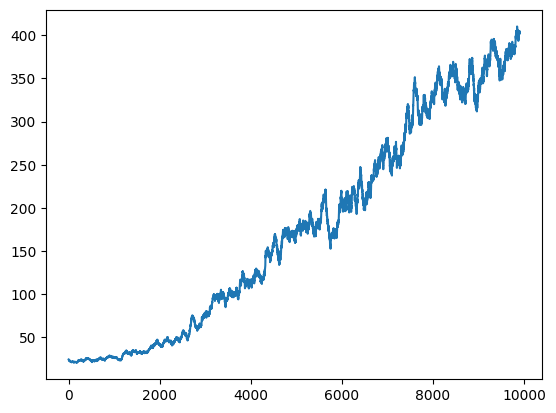

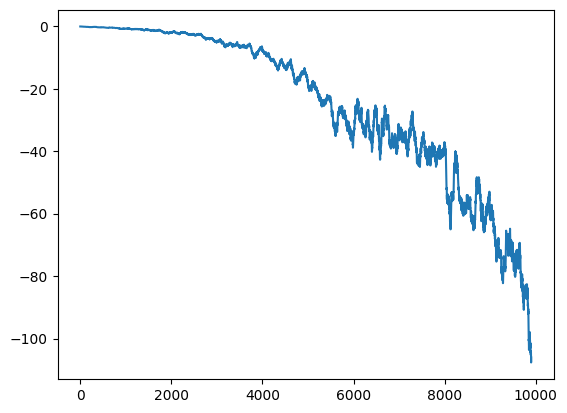

In [42]:
import numpy as np

def moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

plt.figure()
plt.plot(moving_average(rewards, 100))
plt.figure()
plt.plot(moving_average(losses, 100))

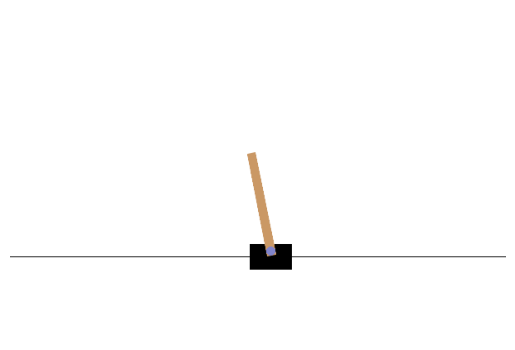

29.0


In [40]:
observation, info = env.reset()

episode_over = False
running_R = 0
while not episode_over:
    frame = env.render()
    clear_output(wait=True)
    plt.imshow(frame)
    plt.axis('off')
    plt.show()
    time.sleep(0.002)

    action = env.action_space.sample()  # agent policy that uses the observation and info
    # probs = policy(torch.from_numpy(observation).view(-1, 4))
    # action = torch.multinomial(probs, num_samples=1).item()
    observation, reward, terminated, truncated, info = env.step(action)
    running_R += reward

    episode_over = terminated or truncated
        
env.close()

print(running_R)

In [43]:
torch.save(policy.state_dict(), f"models/pole/PG_380")